# 1. Introduction/Business Problem

New York City’s demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. With it’s diverse culture , comes diverse food items. New York is named the best city for vegetarians. Coming here, you will have a myriad of vegetarian options at restaurants or mobile food trucks. In addition, many vegetarian events are also held in New York, such as the Vegetarian Food Festival. This report explores which neighborhoods and boroughs of New York City have the most as well as the best vegetarian restaurants. Additionally, I will attempt to answer the questions “Where should I open an vegetarian Restaurant?” and “Where should I stay If I want great vegetarian food?”.

# 2. Data

In order to answer the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

New York City data containing neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

All data related to locations and quality of vegetarian restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

# 3. Approach

The Methodology section will describe the main components of our analysis and predication system. The Methodology section comprises four stages:

- Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.
- FourSquare be used to locate all venues and then filtered by vegetarian restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.
- Data will be sorted based on rankings
- Finally, the data be will be visually assessed using graphing from various Python libraries.

# 4. Analysis

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [141]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import os

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#### Download and Explore Dataset

In [142]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset

# load the data.
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
new_york_data = pd.DataFrame(columns=column_names)

# Then let's loop through the data and fill the dataframe one row at a time.
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

# Quickly examine the resulting dataframe.
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [143]:
new_york_data.shape

(306, 4)

So there are total of 306 different Neighborhoods in New York

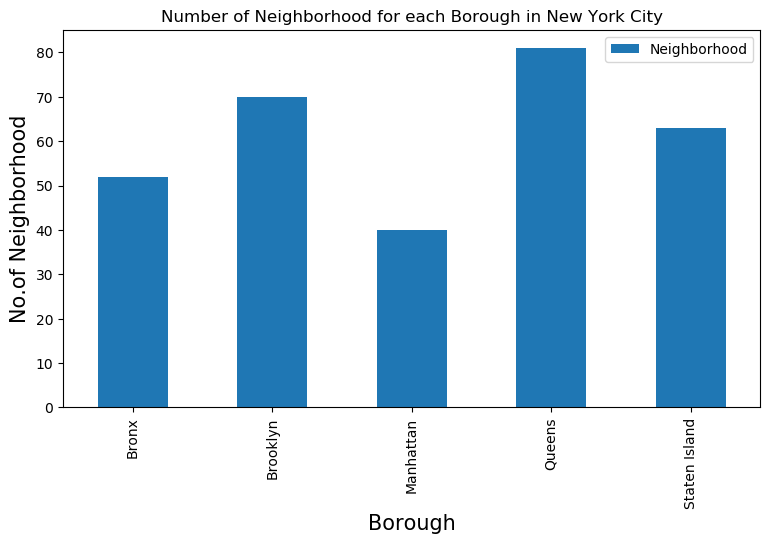

In [144]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods. Now we will collect vegetarian resturants for each Neighborhood

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [7]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'HMGO4ODJSAIUY4TDY1J544ST25MFQP0KNUSHJG2TETXUCUHM'
    CLIENT_SECRET = 'B5L33YNXBB3XGJUCPDJE4E2V3SD50KH1DMH3ZA25I25AXYJ0'
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            lat,
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [8]:
# prepare neighborhood list that contains vegetarian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
vegetarian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    vegetarian_resturants=venues[venues['Category']=='Vegetarian / Vegan Restaurant']   
    print('(',count,'/',len(new_york_data),')','Vegetarian Resturants in '+Neighborhood+', '+Borough+':'+str(len(vegetarian_resturants)))
    for resturant_detail in vegetarian_resturants.values.tolist():
        id, name , category=resturant_detail
        vegetarian_rest_ny = vegetarian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Vegetarian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Vegetarian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Vegetarian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Vegetarian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Vegetarian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Vegetarian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Vegetarian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Vegetarian Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Vegetarian Resturants in Norwood, Bronx:0
( 10 / 306 ) Vegetarian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Vegetarian Resturants in Baychester, Bronx:0
( 12 / 306 ) Vegetarian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Vegetarian Resturants in City Island, Bronx:0
( 14 / 306 ) Vegetarian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Vegetarian Resturants in University Heights, Bronx:0
( 16 / 306 ) Vegetarian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Vegetarian Resturants in Fordham, Bronx:0
( 18

Now that we have got all the vegetarian resturants in new york city , we will analyze it

In [9]:
vegetarian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Brooklyn,Bay Ridge,55c159c5498e6e82b8f62043,Shangri-La Vegetarian
1,Brooklyn,Sunset Park,5548f518498e8f7858764111,Lucky Vegetarian
2,Brooklyn,Crown Heights,5aedf28bbe70780039a690e2,Greedi Vegan
3,Brooklyn,Crown Heights,4ba154a4f964a5204cad37e3,Ital Shak Vegetarian Restaurant
4,Brooklyn,Prospect Heights,4ad8d0e5f964a520f11421e3,Natural Blend


In [10]:
vegetarian_rest_ny.shape

(63, 4)

We got 63 vegetarian Resturants across New York City

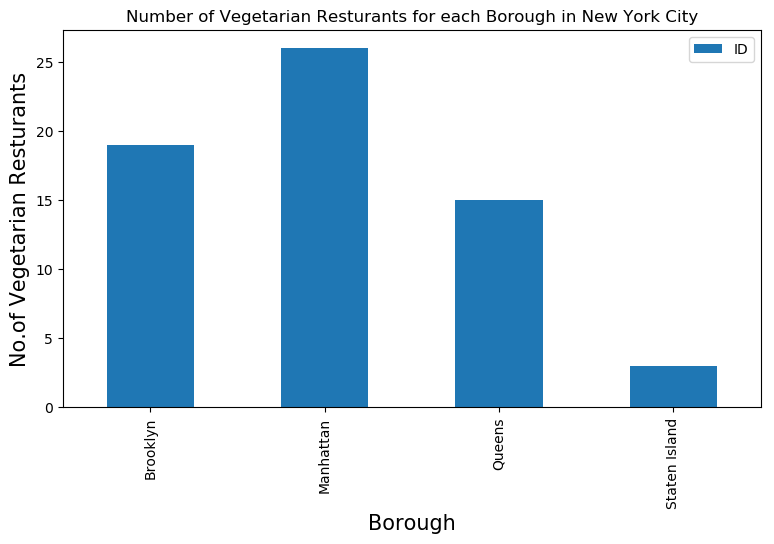

In [11]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Vegetarian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Vegetarian Resturants', fontsize=15)
#giving a bar plot
vegetarian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Manhattan has the largest number of vegetarian resturants

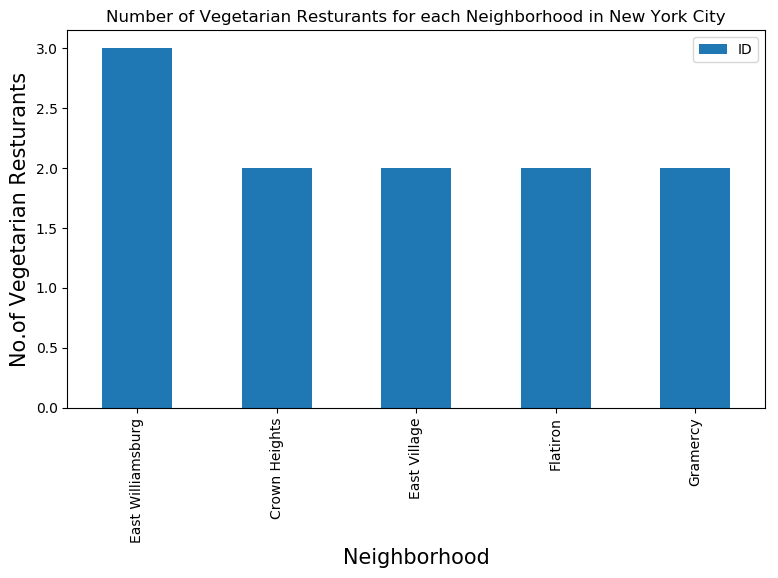

In [17]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Vegetarian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Vegetarian Resturants', fontsize=15)
#giving a bar plot
vegetarian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [27]:
vegetarian_rest_ny[vegetarian_rest_ny['Neighborhood']=='East Williamsburg']

,Borough,Neighborhood,ID,Name
11,Brooklyn,East Williamsburg,4a2048e8f964a520687c1fe3,Champs Diner
12,Brooklyn,East Williamsburg,5169bf17e4b01de80a9b04e5,Vegan Shop Up
13,Brooklyn,East Williamsburg,51ce0320498e6d3591ec3175,Loving Hut


So East Williamsburg in Manhattan has the highest number of Vegetarian Resturants with a total count of 3.

Now we will get the ranking of each resturant for further analysis.

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [28]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'HMGO4ODJSAIUY4TDY1J544ST25MFQP0KNUSHJG2TETXUCUHM'
    CLIENT_SECRET = 'B5L33YNXBB3XGJUCPDJE4E2V3SD50KH1DMH3ZA25I25AXYJ0'
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [29]:
# prepare neighborhood list that contains vegetarian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
vegetarian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in vegetarian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(vegetarian_rest_ny),')','processed')
    vegetarian_rest_stats_ny = vegetarian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                   Name  Likes  Rating  Tips
0  55c159c5498e6e82b8f62043  Shangri-La Vegetarian     15     7.7     6
( 1 / 63 ) processed
                         ID              Name  Likes  Rating  Tips
0  5548f518498e8f7858764111  Lucky Vegetarian      7     7.4     3
( 2 / 63 ) processed
                         ID          Name  Likes  Rating  Tips
0  5aedf28bbe70780039a690e2  Greedi Vegan      8     7.9     3
( 3 / 63 ) processed
                         ID                             Name  Likes  Rating  \
0  4ba154a4f964a5204cad37e3  Ital Shak Vegetarian Restaurant      4     7.1   

   Tips  
0     7  
( 4 / 63 ) processed
                         ID           Name  Likes  Rating  Tips
0  4ad8d0e5f964a520f11421e3  Natural Blend     70     8.6    31
( 5 / 63 ) processed
                         ID                  Name  Likes  Rating  Tips
0  57ddcea8498eec0d30b86391  Modern Love Brooklyn    134     8.6    32
( 6 / 63 ) processed
                     

In [30]:
vegetarian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Bay Ridge,55c159c5498e6e82b8f62043,Shangri-La Vegetarian,15,7.7,6
1,Brooklyn,Sunset Park,5548f518498e8f7858764111,Lucky Vegetarian,7,7.4,3
2,Brooklyn,Crown Heights,5aedf28bbe70780039a690e2,Greedi Vegan,8,7.9,3
3,Brooklyn,Crown Heights,4ba154a4f964a5204cad37e3,Ital Shak Vegetarian Restaurant,4,7.1,7
4,Brooklyn,Prospect Heights,4ad8d0e5f964a520f11421e3,Natural Blend,70,8.6,31


In [31]:
vegetarian_rest_stats_ny.shape

(63, 7)

In [32]:
vegetarian_rest_ny.shape

(63, 4)

So we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [33]:
vegetarian_rest_stats_ny.to_csv('vegetarian_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv file

In [145]:
vegetarian_rest_stats_ny_csv=pd.read_csv('vegetarian_rest_stats_ny.csv')

In [146]:
vegetarian_rest_stats_ny_csv.shape

(63, 7)

In [147]:
vegetarian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Bay Ridge,55c159c5498e6e82b8f62043,Shangri-La Vegetarian,15,7.7,6
1,Brooklyn,Sunset Park,5548f518498e8f7858764111,Lucky Vegetarian,7,7.4,3
2,Brooklyn,Crown Heights,5aedf28bbe70780039a690e2,Greedi Vegan,8,7.9,3
3,Brooklyn,Crown Heights,4ba154a4f964a5204cad37e3,Ital Shak Vegetarian Restaurant,4,7.1,7
4,Brooklyn,Prospect Heights,4ad8d0e5f964a520f11421e3,Natural Blend,70,8.6,31


In [148]:
vegetarian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 7 columns):
Borough         63 non-null object
Neighborhood    63 non-null object
ID              63 non-null object
Name            63 non-null object
Likes           63 non-null float64
Rating          63 non-null float64
Tips            63 non-null float64
dtypes: float64(3), object(4)
memory usage: 3.5+ KB


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis

In [149]:
vegetarian_rest_stats_ny['Likes']=vegetarian_rest_stats_ny['Likes'].astype('float64')

In [150]:
vegetarian_rest_stats_ny['Tips']=vegetarian_rest_stats_ny['Tips'].astype('float64')

In [151]:
vegetarian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 7 columns):
Borough         63 non-null object
Neighborhood    63 non-null object
ID              63 non-null object
Name            63 non-null object
Likes           63 non-null float64
Rating          63 non-null float64
Tips            63 non-null float64
dtypes: float64(3), object(4)
memory usage: 3.5+ KB


Now the data types looks correct

In [152]:
# Resturant with maximum Likes
vegetarian_rest_stats_ny.iloc[vegetarian_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood           East Williamsburg
ID              4a2048e8f964a520687c1fe3
Name                        Champs Diner
Likes                                652
Rating                               8.9
Tips                                 273
Name: 11, dtype: object

In [153]:
# Resturant with maximum Rating
vegetarian_rest_stats_ny.iloc[vegetarian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              54148bc6498ea7bb8c05b70a
Name                         Juice Press
Likes                                 85
Rating                               9.1
Tips                                  12
Name: 29, dtype: object

In [154]:
# Resturant with maximum Tips
vegetarian_rest_stats_ny.iloc[vegetarian_rest_stats_ny['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood           East Williamsburg
ID              4a2048e8f964a520687c1fe3
Name                        Champs Diner
Likes                                652
Rating                               8.9
Tips                                 273
Name: 11, dtype: object

Now lets visualize neighborhood with maximum average rating of resturants

In [155]:
ny_neighborhood_stats=vegetarian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [156]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
0,Battery Park City,9.1
45,Tribeca,9.1
6,Civic Center,9.1
12,Flatiron,9.0
49,West Village,9.0
39,Soho,9.0
24,Little Italy,9.0
17,Greenwich Village,9.0
3,Bushwick,8.9
23,Lenox Hill,8.8


Above are the top neighborhoods with top average rating of Vegetarian resturants

In [157]:
ny_borough_stats=vegetarian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [158]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.711538
0,Brooklyn,7.731579
3,Staten Island,7.200000
2,Queens,6.133333


Similarly these are the average rating of Vegetarian Resturants for each Borough

Lets visualize it

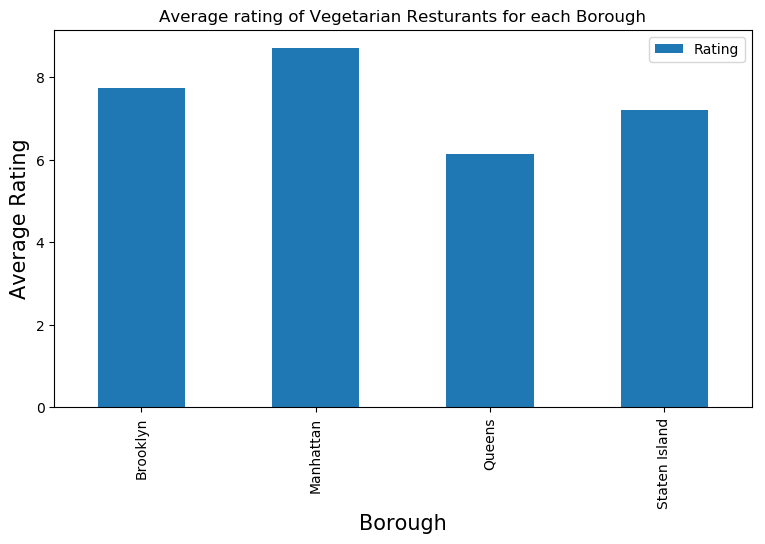

In [159]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Vegetarian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
vegetarian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [160]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [161]:
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Battery Park City,9.1
6,Civic Center,9.1
12,Flatiron,9.0
17,Greenwich Village,9.0
24,Little Italy,9.0
39,Soho,9.0
45,Tribeca,9.1
49,West Village,9.0


We will join this dataset to original new york data to get lonitude and latitude

In [162]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Battery Park City,40.711932,-74.016869,9.1
1,Manhattan,Civic Center,40.715229,-74.005415,9.1
2,Manhattan,Flatiron,40.739673,-73.990947,9.0
3,Manhattan,Greenwich Village,40.726933,-73.999914,9.0
4,Manhattan,Little Italy,40.719324,-73.997305,9.0
5,Manhattan,Soho,40.722184,-74.000657,9.0
6,Manhattan,Tribeca,40.721522,-74.010683,9.1
7,Manhattan,West Village,40.734434,-74.006180,9.0


Now we will show this data on a map

Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [163]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [164]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose

In [165]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [166]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Now that we have visualized the Neighborhoods.
Lets Visualize Boroughs based on average Rating

In [135]:
# download geojson file
!wget --quiet https://data.cityofnewyork.us/api/views/7t3b-ywvw/rows.json?accessType=DOWNLOAD -O BoroughBoundaries.json
    
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [136]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'BoroughBoundaries.json'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
ny_map

# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

# 5. Results / Conclusion

- Manhattan and Brooklyn have the best rated Vegetarian restaurants on average.

- Manhattan and Brooklyn have the least amount of Vegetarian restaurants per borough.

- However, of note, East Williamsburg of Brooklyn is the neighborhood in all of NYC with the most Vegetarian Restaurants. 

- Despite Manhattan having the least number of neighborhoods in all five boroughs, it has the most Vegetarian restaurants. 

- Based on this information, I would state that Manhattan and Brooklyn are the best locations for Vegetarian cuisine in NYC. 

- To have the best shot of success, I would open an Vegetarian restaurants in Brooklyn. Brooklyn has multiple neighborhoods with average ratings exceeding 8.0 of a scale of 1.0 to 10.0 and has the least number of Vegetarian restaurants making competition easier than in other boroughs. 

- Finally, I would go to East Williamsburg in Brooklyn for the best Vegetarian food based on 652 likes.

- As a final note, all of the above analysis is depended on the adequacy and accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.
